Pembuatan Model Klasifikasi Sampah

Source dataset = https://www.kaggle.com/datasets/mostafaabla/garbage-classification

Import data yang Diperlukan

In [29]:
import os
import pandas as pd
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
import shutil
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.model_selection import train_test_split
import pathlib

In [2]:
!pip install kaggle

In [3]:
! kaggle datasets download mostafaabla/garbage-classification

Dataset URL: https://www.kaggle.com/datasets/mostafaabla/garbage-classification
License(s): ODbL-1.0
garbage-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
extract_dir = 'data'
zip_file = 'garbage-classification.zip'
data_zip = zipfile.ZipFile(zip_file, 'r')
data_zip.extractall(extract_dir)
data_zip.close()
extract_dir = '/content/data/garbage_classification'
print(f"File ZIP '{zip_file}' telah diekstrak ke dalam direktori '{extract_dir}'")

File ZIP 'garbage-classification.zip' telah diekstrak ke dalam direktori '/content/data/garbage_classification'


In [5]:
def count_images(root_dir):
    image_counts = defaultdict(int)
    for root, dirs, files in os.walk(root_dir):
        data = [f for f in files if f.endswith('.jpg')]
        if data:
            category = os.path.basename(root)
            image_counts[category] += len(data)
    return image_counts

image_counts = count_images(extract_dir)

for category, count in image_counts.items():
    print(f"Jumlah gambar '{category}': {count}")

total_images = sum(image_counts.values())
print(f"Total jumlah gambar keseluruhan: {total_images}")

Jumlah gambar 'brown-glass': 607
Jumlah gambar 'shoes': 1977
Jumlah gambar 'paper': 1050
Jumlah gambar 'cardboard': 891
Jumlah gambar 'plastic': 865
Jumlah gambar 'metal': 769
Jumlah gambar 'white-glass': 775
Jumlah gambar 'clothes': 5325
Jumlah gambar 'green-glass': 629
Jumlah gambar 'biological': 985
Jumlah gambar 'battery': 945
Jumlah gambar 'trash': 697
Total jumlah gambar keseluruhan: 15515


<ipython-input-6-853bb83cc71d>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot_data.set_xticklabels(plot_data.get_xticklabels(), rotation=45)


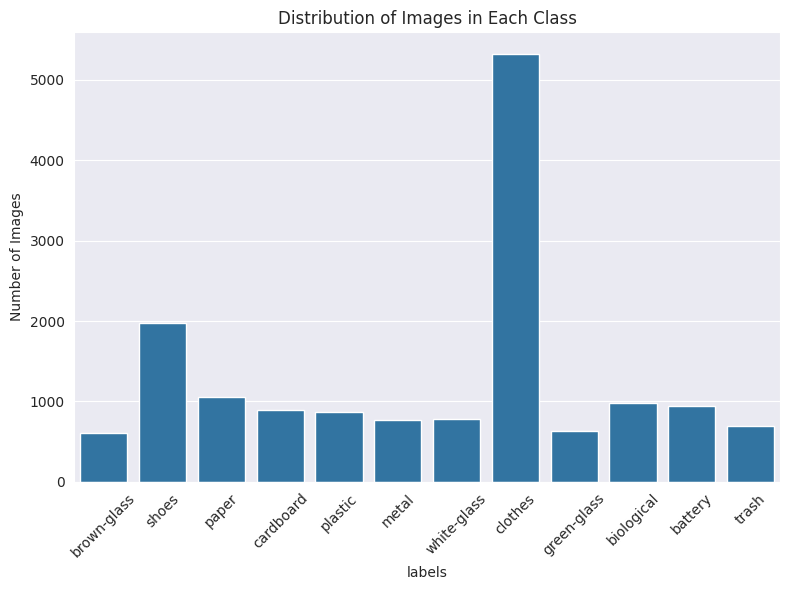

In [6]:
file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(extract_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(x='labels', data=distribution_train)
plot_data.set_title('Distribution of Images in Each Class')
plot_data.set_xticklabels(plot_data.get_xticklabels(), rotation=45)
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

In [7]:
def sample_images(root_dir, category, max_samples=1250):
    category_dir = os.path.join(root_dir, category)
    all_images = [os.path.join(category_dir, f) for f in os.listdir(category_dir) if f.endswith('.jpg')]
    if len(all_images) > max_samples:
        sampled_images = resample(all_images, replace=False, n_samples=max_samples, random_state=42)
    else:
        sampled_images = all_images
    return sampled_images

balanced_dir = 'balanced_dir'
os.makedirs(balanced_dir, exist_ok=True)

In [8]:
for category in image_counts.keys():
    os.makedirs(os.path.join(balanced_dir, category), exist_ok=True)
    sampled_images = sample_images(extract_dir, category)
    for img_path in sampled_images:
        shutil.copy(img_path, os.path.join(balanced_dir, category))

print(f"Data telah didistribusikan dengan baik dan disimpan dalam direktori '{balanced_dir}'")

Data telah didistribusikan dengan baik dan disimpan dalam direktori 'balanced_dir'


Cek tabel Distribusi

<ipython-input-9-be72abbbc3af>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot_data.set_xticklabels(plot_data.get_xticklabels(), rotation=45)


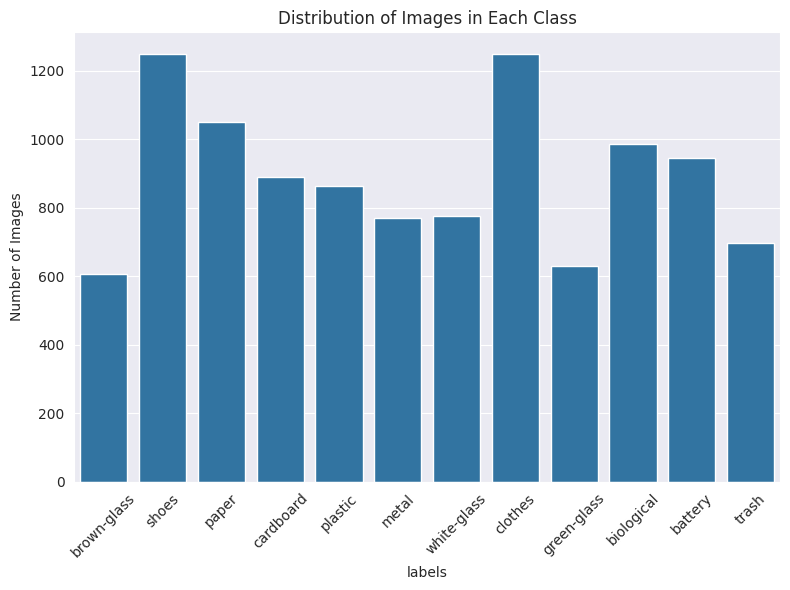

In [9]:
file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(balanced_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(x='labels', data=distribution_train)
plot_data.set_title('Distribution of Images in Each Class')
plot_data.set_xticklabels(plot_data.get_xticklabels(), rotation=45)
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

Split data train dan test

In [10]:
def split_data(root_dir, train_dir, val_dir, train_size=0.8, val_size=0.2):
    for category in os.listdir(root_dir):
        category_dir = os.path.join(root_dir, category)
        images = [os.path.join(category_dir, img) for img in os.listdir(category_dir) if img.endswith('.jpg')]

        train, val = train_test_split(images, test_size=val_size, random_state=42)

        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(val_dir, category), exist_ok=True)

        for img in train:
            shutil.copy(img, os.path.join(train_dir, category))
        for img in val:
            shutil.copy(img, os.path.join(val_dir, category))

train_dir = 'train_set'
test_dir = 'test_set'
split_data(balanced_dir, train_dir, test_dir)

Implementasi Data Augmentasi

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 8568 images belonging to 12 classes.
Found 2145 images belonging to 12 classes.


Buat Model

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(12, activation='softmax')
])

Kompile model yang sudah dibuat

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Implementasi Fungsi Callback untuk pelatihan Model

In [19]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (logs.get('val_accuracy') >= 0.85 and logs.get('accuracy') >= 0.85):
            print("\nPelatihan dihentikan karena mencapai target yang diinginkan")
            self.model.stop_training = True

callbacks = [
    MyCallback(),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
]

In [20]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=75,
    callbacks=[callbacks]
)

Epoch 1/75
268/268 [==============================] - ETA: 0s - loss: 2.2290 - accuracy: 0.1933
Epoch 1: val_accuracy improved from -inf to 0.35991, saving model to model.h5
268/268 [==============================] - 70s 247ms/step - loss: 2.2290 - accuracy: 0.1933 - val_loss: 1.8577 - val_accuracy: 0.3599 - lr: 5.0000e-04
Epoch 2/75
268/268 [==============================] - ETA: 0s - loss: 1.8151 - accuracy: 0.3553
Epoch 2: val_accuracy improved from 0.35991 to 0.44988, saving model to model.h5
268/268 [==============================] - 65s 242ms/step - loss: 1.8151 - accuracy: 0.3553 - val_loss: 1.6201 - val_accuracy: 0.4499 - lr: 5.0000e-04
Epoch 3/75
268/268 [==============================] - ETA: 0s - loss: 1.6364 - accuracy: 0.4348
Epoch 3: val_accuracy improved from 0.44988 to 0.49277, saving model to model.h5
268/268 [==============================] - 67s 251ms/step - loss: 1.6364 - accuracy: 0.4348 - val_loss: 1.4759 - val_accuracy: 0.4928 - lr: 5.0000e-04
Epoch 4/75
268/268 

Plot evaluasi Model untuk Akurasi train dan validation

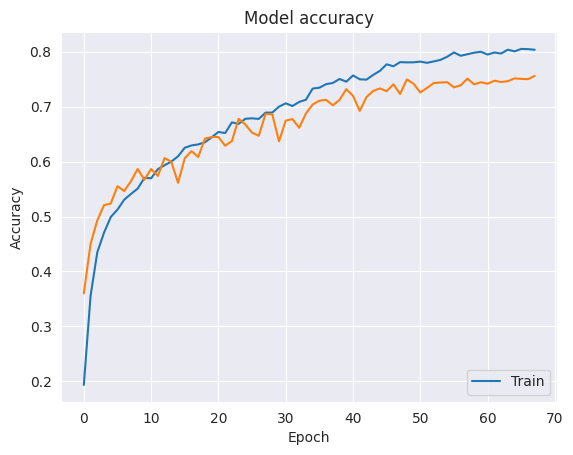

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

Plot evaluasi Model untuk Loss train dan validation

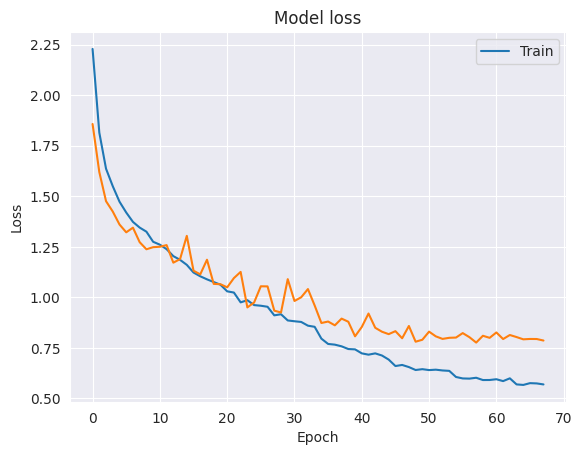

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

Convert format model.h5 ke model tensorflowJs agar bisa di deploy ke web

In [23]:
!pip install tensorflowjs
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 91.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 106.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 92.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 110.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 76.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB

2024-07-24 08:32:01.732072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 08:32:01.776829: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 08:32:01.776898: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-24 08:32:03.002440: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Kompres agar bisa didownload dari colab

In [24]:
with zipfile.ZipFile('tfjs_model.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk('tfjs_model'):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), 'tfjs_model'))

Kemudian save juga agar bisa digunakan di mobile Apps

In [25]:
tf.saved_model.save(model, '/Mymodel')

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x792a201ba830>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x792a201ba830>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [30]:
converter = tf.lite.TFLiteConverter.from_saved_model('Mymodel')
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('trashKlass.tflite')
tflite_model_file.write_bytes(tflite_model)

2551900